In [1]:
"""
# Header ------------------------------------------------------------------
"""
import pyjags
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from core import *
from model import build
from scipy.stats import poisson
np.set_printoptions(precision=10)

## Serius

In [2]:
# data ----------------------------------------------------------

np.random.seed(123)

df = pd.read_csv("experiment1.csv")

In [3]:
models=build()

In [7]:
T = np.unique(df["Year"]).shape[0]

d15n=df.loc[ df["Year"]== 2015, ["Population"] ].values
d16n=df.loc[ df["Year"]== 2016, ["Population"] ].values

d15y=df.loc[ df["Year"]== 2015, ["Property crime"] ].values
d16y=df.loc[ df["Year"]== 2016, ["Property crime"] ].values

n=np.array([d15n, d16n]).squeeze(-1).T
y=np.array([d15y, d16y]).squeeze(-1).T

df["Regions"] = pd.Categorical(df["Regions"])
df["Year"] = pd.Categorical(df["Year"])

region = df["Regions"].cat.codes.values.reshape(-1)
year = df["Year"].cat.codes.values.reshape(-1)

nregions = np.unique(region).shape[0]
nstates = n.shape[0]

In [5]:
def eplot(model, y, n, it = 10000, chains=4,sslice =1000):
    samples = sample(model[0], model[2], varnames=model[1], chains=chains, trials=it)
    
        
    y_pred = np.mean( samples['y_pred'][:,:,-sslice:,:], axis=(-1,-2) )
    theta_mean = np.mean( samples['theta'][:,:,-sslice:,:], axis=(-1,-2) )
    theta_median = np.median( samples['theta'][:,:,-sslice:,:], axis=(-1,-2) )
    
    
    loglikl_mean = np.sum(poisson.logpmf(y.ravel(),n.ravel() * theta_mean.ravel()))
    loglikl_median = np.sum(poisson.logpmf(y.ravel(),n.ravel() * theta_median.ravel()))
    
    
    y_predmean = n.ravel() * theta_mean.ravel()
    mse_mean = np.sum(((y.ravel()-y_predmean)/y.ravel())**2) 
    
    y_predmd = n.ravel() * theta_median.ravel()
    mse_md = np.sum(((y.ravel()-y_predmd)/y.ravel())**2) 
    
    aic_mean = 2* model[3] - 2 * loglikl_mean
    aic_md = 2* model[3] - 2 * loglikl_median
    sic_mean = 2* np.log(len(y.ravel()))*model[3] - 2 * loglikl_mean
    sic_md = 2* np.log(len(y.ravel()))*model[3] - 2 * loglikl_median
    
    print("######################")
    
    print("### mean: ---")
    print("Log likelihood: " + str(loglikl_mean)) 
    print("aic: "+ str(aic_mean))
    print("sic: "+ str(sic_mean))
    print("chi-square : " + str(mse_mean))
    
    print("### median: ---")
    print("Log likelihood: " + str(loglikl_median))
    print("aic: "+ str(aic_md))
    print("sic: "+ str(sic_md))
    print("chi-square : " + str(mse_md))
    
    print("######################")
    #analyse_fit(model[1],model[0])
    
    plot_predictive(
        n.ravel(),
        y.ravel(), 
        y_pred.ravel())
    #plt.scater()
    plt.show()

# notation

## nation, region, state, time
### time - i - ar1 lin, q - ar1 quad, s - stationary 
### region, state, natio - i - independent, f - fixed effect, c - car effect, s - sar effect

adapting: iterations 4000 of 4000, elapsed 0:00:03, remaining 0:00:00
sampling: iterations 10820 of 40000, elapsed 0:00:07, remaining 0:00:20
sampling: iterations 25340 of 40000, elapsed 0:00:17, remaining 0:00:10
sampling: iterations 39988 of 40000, elapsed 0:00:28, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:28, remaining 0:00:00
######################
### mean: ---
Log likelihood: -1242.1058859480818
aic: 2624.2117718961636
sic: 3134.426497775956
chi-square : 0.025953646876006063
### median: ---
Log likelihood: -1231.6137176997781
aic: 2603.2274353995563
sic: 3113.4421612793485
chi-square : 0.02567137246327859
######################
chi-square : 0.025936618020765103


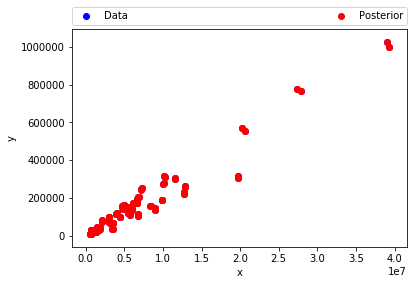

In [8]:
eplot(models["fcfq"], y = y, n=n, it=10000, sslice=4000)